# Example notebook for the _MOSES Sternfahrt 4_

This notebook downloads data from the MOSES Sternfahrt 4 mission using the restAPI and gets the model parameters of the ECOSMO model via the `ecosmo.api` module.

## The MOSES 4 Show Case

We select some sensors from the MOSES 4 Sternfahrt. These have been taken from the O2A Data Web Services at https://dashboard.awi.de/data-xxl

In [1]:
sensors = [
    "small_scale_facility:pfb_awi_751801:longitude_0001",
    "small_scale_facility:pfb_awi_751801:latitude_0001",
    "small_scale_facility:pfb_awi_751801:temperature_0001",
    "small_scale_facility:pfb_awi_751801:temperature_sbe45_0001",
    "small_scale_facility:pfb_awi_751801:salinity_sbe45_0001",
]

## The MOSES 4 Show Case

To download the data, we use the O2A data-web-services package (https://github.com/o2a-data/o2a-data-dws).

In [2]:
from dws import dws

df = dws.get(sensors, "2020-01-01", "2020-12-31")

df.columns = [col.split(":")[-1].replace("_0001", "").replace(" (mean) ", " ") for col in df.columns]
df

,datetime,longitude [degree],latitude [degree],temperature [°C],temperature_sbe45 [°C],salinity_sbe45 [PSU]
0,2020-05-12 07:00:00,8.691301,53.896932,12.544424,12.371957,20.202211
1,2020-05-12 08:00:00,8.599985,53.961046,12.372096,12.299104,22.809384
2,2020-05-12 09:00:00,8.455386,53.986614,12.250490,12.176458,25.997186
3,2020-05-12 10:00:00,8.346667,53.995425,12.038740,11.971432,27.822074
4,2020-05-12 11:00:00,8.282148,53.987900,11.859090,11.793513,28.932331
5,2020-05-12 12:00:00,8.229221,53.975422,11.774803,11.702069,29.361237
6,2020-05-12 13:00:00,8.146051,53.905654,11.126204,11.038496,30.341012
7,2020-05-12 14:00:00,8.153086,53.795732,11.725587,11.643404,30.948018
8,2020-05-12 15:00:00,8.260179,53.724413,12.407907,12.340302,29.107627


## The ECOSMO Backend Module

We created a backend module that loads climate model data and extracts the data along a specific path.

```python
def get_model_parameter(
    names: Union[Parameter, List[Parameter]],
    time: List[datetime.datetime],
    lat: List[float],
    lon: List[float],
) -> DataFrame:
    """Get ECOSMO model parameters for a given 3D path.

    This function takes a certain list of parameters and a 3D path, denoted by
    time, latitude and longitude, and extracts the data from the highresolution
    model output.

    Parameters
    ----------
    names : Union[Parameter, List[Parameter]]
        The parameter names to extract, see :class:`Parameter`.
    time : List[datetime.datetime]
        The list of times for each point.
    lat : List[float]
        The list of latitudes in degrees North for each point. Must be of the
        same length as `time` and `lon`.
    lon : List[float]
        The list of longitudes in degrees East for each point. Must be of the
        same length as `time` and `lat`.

    Returns
    -------
    DataFrame
        The dataframe with the selected model parameters for the given path.
    """
    if isinstance(names, str):
        names = [names]
    params = [param.value for param in map(Parameter, names)]

    if len(lat) != len(lon) or len(lat) != len(time):
        raise ValueError("lat, time and lon must all be of the same length!")

    with xr.open_dataset(
        osp.join(data_dir, "ecosmo-ute-daewel-20200501-20200531.nc")
    ) as ds:

        ds = ds[params].isel(layer=0).drop_vars("layer")
        lon_da = xr.DataArray(lon, dims="path")
        lat_da = xr.DataArray(lat, dims="path")
        time_da = xr.DataArray(time, dims="path")
        ds = ds.interp(lon=lon_da, lat=lat_da, time=time_da)

    # convert the data to a pandas dataframe
    return ds.to_dataframe()
```

## Using the ECOSMO api module

Now we call the backend module (assuming that it is connected already).

In [3]:
from ecosmo.api import get_model_parameter

model_data = get_model_parameter(
    ["temp", "salt"], 
    df.datetime.to_list(), 
    df["latitude [degree]"].to_list(), 
    df["longitude [degree]"].to_list()
)

connection to ws://rz-vm154.gfz-potsdam.de:8082/ws/v2/producer/non-persistent/public/digital-earth/ecosmo established
connection to ws://rz-vm154.gfz-potsdam.de:8082/ws/v2/consumer/non-persistent/public/digital-earth/ecosmo_ZBgTQKCl/python-backend-2021-01-21T23:37:49.118556 established
request successful


In [4]:
model_data

,temp,salt,lon,lat,time
0,NaN,NaN,8.691301,53.896932,1589266800000
1,11.983256,26.690295,8.599985,53.961046,1589270400000
2,NaN,NaN,8.455386,53.986614,1589274000000
3,10.917467,26.500072,8.346667,53.995425,1589277600000
4,11.213279,27.359059,8.282148,53.987900,1589281200000
5,11.821529,32.123666,8.229221,53.975422,1589284800000
6,10.973425,34.350685,8.146051,53.905654,1589288400000
7,NaN,NaN,8.153086,53.795732,1589292000000
8,NaN,NaN,8.260179,53.724413,1589295600000


## Model vs. Observations

Now we can merge the `temp` and `salt` columns into our observations and plot them.

In [5]:
df["ecosmo_temperature"] = model_data.temp.values
df["ecosmo_salinity"] = model_data.salt.values

<AxesSubplot:xlabel='salinity_sbe45 [PSU]', ylabel='ecosmo_salinity'>

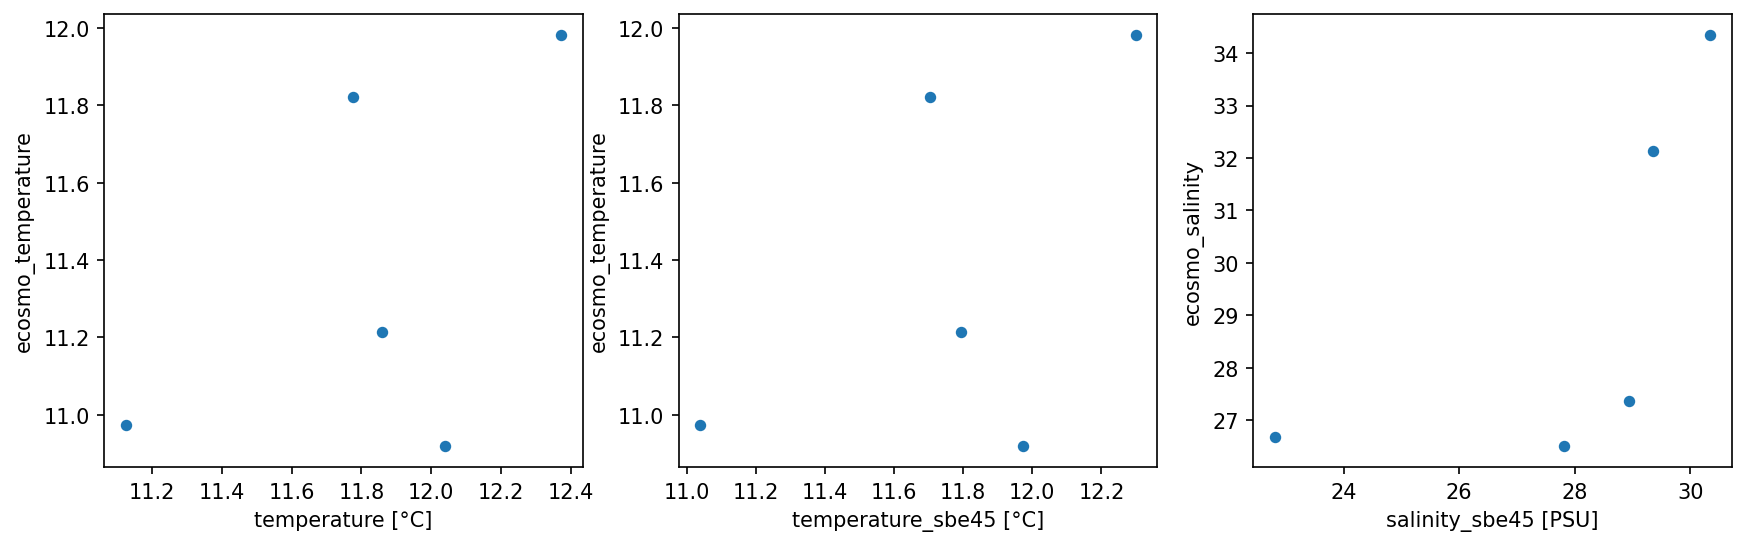

In [6]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(14, 4), dpi=150)
df.plot.scatter("temperature [°C]", "ecosmo_temperature", ax=axes[0])
df.plot.scatter("temperature_sbe45 [°C]", "ecosmo_temperature", ax=axes[1])
df.plot.scatter("salinity_sbe45 [PSU]", "ecosmo_salinity", ax=axes[2])